# LGU+ 경진대회 - 베이스라인  
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
- 구현된 모델의 검증 데이터셋과 리더보드의 성능을 확인

<참고자료>
https://supkoon.tistory.com/28

베이스라인의 간단한 설명은 아래와 같습니다.

데이터 전처리 파트에서는 중복된 시청이력을 삭제하고 80:20으로 학습 데이터와 검증 데이터를 생성합니다. 

NeuMF 모델을 참고하여 메타 정보를 결합할 수 있는 모델을 구현합니다. 그리고, 해당 모델을 학습시켜주는 코드와 추론 코드의 구현을 진행합니다. 

이후, 생성한 모델의 하이퍼파라미터와 optimizer, loss를 설정하고 학습을 진행합니다. 

마지막으로, 검증 데이터에 대해서 가장 높은 성능을 보인 가중치 파일을 불러와서 모든 유저에 대해 추천결과를 생성하고 생성된 파일을 저장합니다. 

이후, submission 폴더 내의 submission.csv 파일을 리더보드에 제출하면 베이스라인의 성능을 확인할 수 있습니다. 보다 자세한 내용은 baseline.ipynb 파일을 참고하시기 바랍니다. 

# 논문 분석
https://leehyejin91.github.io/post-ncf/

## 목차 
- 데이터 전처리 
    - 기본 설정
    - 데이터 불러오기 
    - 학습 및 검증 데이터 생성 
- NeuMF 구현    
    - 모델 구현 
    - 학습 및 추론 코드 구현
- 모델 학습 
    - 하이퍼파라미터 설정 & 최적화 기법 설정
    - 모델 학습 
    - 학습 과정 시각화 
- 제출 
    - 모든 유저에 대해 추천 결과 생성
    - 저장 

## 데이터 전처리
### 기본 설정

In [ ]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 하이퍼 파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25
    seed = 42
    neg_ratio = 100     # negative sampling할 때, negative sample 활용 비율
    test_size = 0.2

In [ ]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [ ]:
# 경로 설정
data_path = '../data'
saved_path = './saved'
output_path = './submission'

### 데이터 불러오기
- history_data : 시청 시작 데이터
- profile_data : 프로필 정보 
- meta_data : 콘텐츠 일반 메타 정보

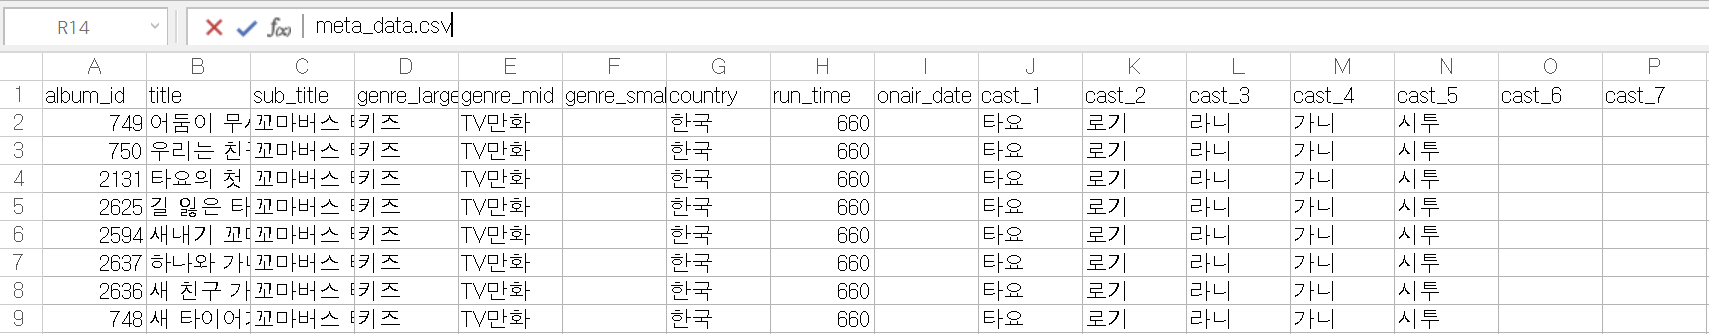

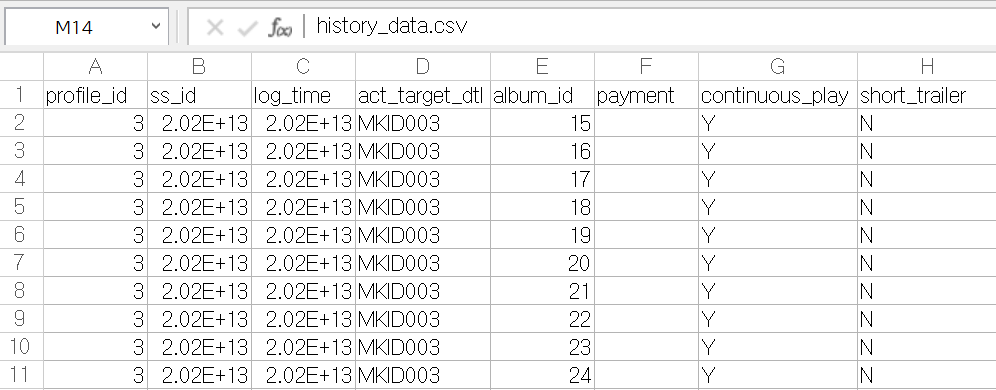

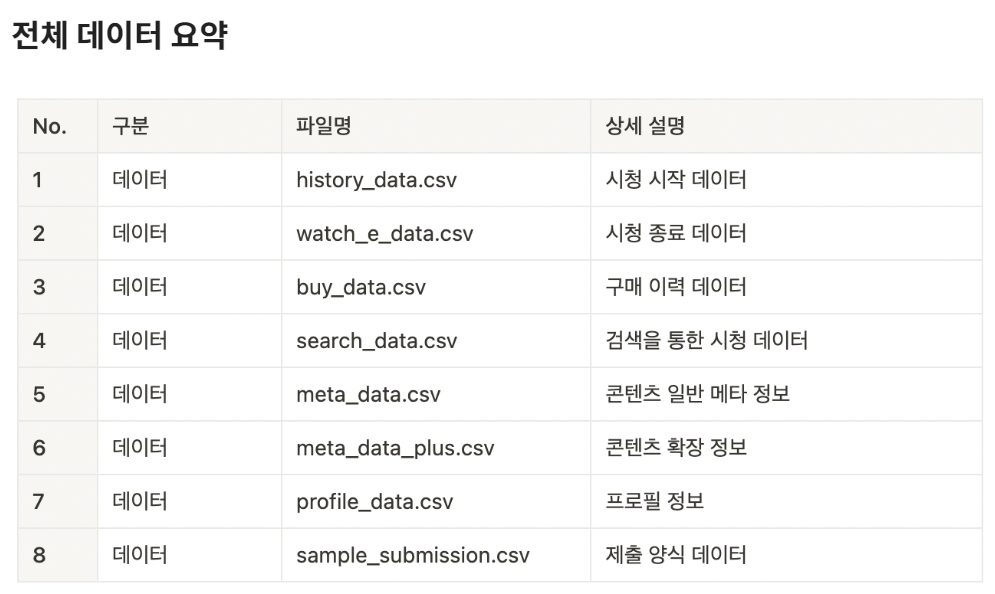

In [ ]:
# 데이터 불러오기 
history_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/Colab Notebooks/LG/LG_datasets/history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/Colab Notebooks/LG/LG_datasets/profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/Colab Notebooks/LG/LG_datasets/meta_data.csv'), encoding='utf-8')

In [ ]:
#!gzip -dc '/content/drive/MyDrive/Colab Notebooks/LG/LG_datasets/data.tar.gz' | tar -tvf -

### 학습 및 검증 데이터 생성 
- train : 시청 이력의 80%를 사용 
- valid : 시청 이력의 20%를 사용 

In [ ]:
# 데이터 전처리 (중복 제거) 
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 

# .sort_values(by='정렬의 기준이 되는 컬럼')
# 행 인덱스 초기화 : reset_index() -> 인덱스를 다시 처음부터 재배열 (drop=True옵션을 주면 기존 인덱스를 버리고 재배열)
# .drop_duplicates(subset=['중복제거의 대상 컬럼']

data = history_df[['profile_id', 'log_time', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)

In [ ]:
data['rating'] = 1

data   # gt > label

,profile_id,log_time,album_id,rating
0,3,20220301115719,15,1
1,3,20220301115809,16,1
2,3,20220301115958,17,1
3,3,20220301120118,18,1
4,3,20220301120229,19,1
...,...,...,...,...
899247,33032,20220427155668,381,1
899248,33032,20220427155680,381,1
899249,33032,20220427155810,125,1
899250,33032,20220427155838,125,1


In [ ]:
# 초기 셋팅값

cfg.n_users = data.profile_id.max()+1    # 33033
cfg.n_items = data.album_id.max()+1

In [ ]:
cfg.n_users

33033

In [ ]:
# 학습 및 검증 데이터 분리 8:2
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed,
)

print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (719401, 4)
검증 데이터 크기: (179851, 4)


In [ ]:
# Matrix 형태로 변환 

# LIL (Linked List Matrix) : row, column 의 array 대신 row 의 수 만큼의 linked list 를 사용하여 행렬을 표현
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))   # [cfg.n_users] X [cfg.n_items] 크기의 행렬 생성

# tqdm : progress bar > 진행률 확인 가능
for (p, _, i, r) in tqdm(train):
    matrix[p, i] = r

train = sparse.csr_matrix(matrix)   # numpy array를 압축 희소 행렬로 변환
train = train.toarray()    # 압축 희소 행렬을 다시 numpy array로 변환
print("train 형태: \n", train)

  0%|          | 0/719401 [00:00<?, ?it/s]

train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


matrix 자료구조 참고 : https://rfriend.tistory.com/551

In [ ]:
# 유저 특징 정보 추출 
profile_df = profile_df.set_index('profile_id')     # 인덱스의 열로 'profile_id' 설정
user_features = profile_df[['age']].to_dict()      # 'age'만을 feature로 추출, df -> dictionary로 변환
print("user_id 3의 age 정보 :", user_features['age'][3])

user_id 3의 age 정보 : 5


In [ ]:
profile_df

,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
profile_id,,,,,,,,
3,F,5,P02,P04,P07,K01,K03,K04
5,M,5,P07,P08,P06,K05,K08,K09
7,F,9,P05,P03,NaN,K06,K04,NaN
12,M,6,P03,P06,P02,K09,K07,K03
16,F,12,P03,P06,P01,K01,K06,K04
...,...,...,...,...,...,...,...,...
33022,M,1,P04,NaN,NaN,K04,K08,NaN
33023,M,5,P06,P03,P07,K08,K04,K05
33026,F,8,P01,P03,P08,K05,K09,K06


In [ ]:
user_features  # 나이만.

In [ ]:
# 아이템 특징 정보 추출 
meta_df = meta_df.set_index('album_id')    # 인덱스의 열로 'album_id' 설정

# 범주형 데이터를 수치형 데이터로 변경 
le = LabelEncoder()
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])    # genre_mid 중분류 장르 > 수치형 데이터로
item_features = meta_df[['genre_mid']].to_dict()
print("album_id 749의 genre_mid 정보 :", item_features['genre_mid'][749])

album_id 749의 genre_mid 정보 : 1


In [ ]:
meta_df

,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
album_id,,,,,,,,,,,,,,,
749,어둠이 무서워요,꼬마버스 타요1,키즈,1,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
750,우리는 친구,꼬마버스 타요1,키즈,1,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2131,타요의 첫 운행,꼬마버스 타요1,키즈,1,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2625,길 잃은 타요,꼬마버스 타요1,키즈,1,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2594,새내기 꼬마 버스의 하루,꼬마버스 타요1,키즈,1,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39873,로티프렌즈와 색칠놀이! - 그리피 ＆ 사탕 바구니,로티프렌즈 미술놀이,키즈,5,NaN,한국,477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39874,로티프렌즈와 색칠놀이! - 베블리 ＆ 꽃,로티프렌즈 미술놀이,키즈,5,NaN,한국,466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4779,손가락을 빨게 돼요,4-5세,키즈,23,NaN,한국,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 추출한 특징 정보의 속성을 저장 > side-info selection
cfg.n_genres = meta_df['genre_mid'].nunique()   # 중분류 장르
cfg.n_continuous_feats = 1    # age

## NeuMF 구현


### 모델 구현 
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
    - continuous feature (age)와 categorical feature (genre_mid)를 같이 학습할 수 있도록 결합

참고 자료 : 신경망을 사용한 Matrix Factorization 모델과 NeuMF(Neural Collaborative Filtering)\ https://glanceyes.tistory.com/entry/%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%84-%EC%82%AC%EC%9A%A9%ED%95%9C-Matrix-Factorization-%EB%AA%A8%EB%8D%B8%EA%B3%BC-NeuMF

![](http://drive.google.com/uc?export=view&id=1tpajTLipLoFdvLICO-alAxeoKAE8-k61)

In [ ]:
## GMF와 MLP -> 유저와 아이템 간의 임베딩 벡터로 구성

class NeuMF(nn.Module):
  """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """

    # **kwargs : 딕셔너리 형태로 값을 저장, 파라미터 명을 같이 보내는 가변인자를 위한 변수
    def __init__(self, cfg):
    #      def __init__(self, num_factors, num_users, num_items, nums_hiddens, **kwargs):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음
        """
        super(NeuMF, self).__init__()   # super(NeuMF, self).__init__(**kwargs)
        self.n_users = cfg.n_users  #  사용자
        self.n_items = cfg.n_items  #  콘텐츠
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim   
        self.n_continuous_feats = cfg.n_continuous_feats  # age
        self.n_genres = cfg.n_genres    # 중분류
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        # mf: Generalized Matrix Factorization > 유저와 아이템 간의 선형적 관계 파악
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        # MLP MF : Multi-Layer Perceptron Matrix Factorization > 유저와 아이템 간의 비선형적 관계 파악
        # MF에 layer 여러 개 추가, 각 layer마다 비선형함수 적용
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
                
        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)
        
        # MLP의 구조, (ReLU는 기본 활성화함수)
        self.mlp_layers = nn.Sequential(
            nn.Linear(2*self.emb_dim + self.n_genres//2 + self.n_continuous_feats, self.layer_dim),  
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim, self.layer_dim//2),  
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)    # 가중치 초기화 함수 적용
        

# 가중치 초기화
    def _init_weights(self, module): 
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)  # 평균이 0이고, 표준편차가 1인 정규 분포의 모든 가중치를 초기화
            # std값이 작을 수록 성능이 향상됨. 0.15로 둬볼까..?  
        elif isinstance(module, nn.Linear):   
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)    # 모든 편향을 0으로 초기화
    
    # forward(self, x, y) = x * y 순전파 > 역전파에 필요한 변수 저장.
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        user_embedding_mf = self.user_embedding_mf(user_indices)    # 유저의 인덱스 정보 mf에 임베딩
        item_embedding_mf = self.item_embedding_mf(item_indices)  # 아이템의 인덱스 정보 mf에 임베딩
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)   # 단순 곱셈 (선형이니까.) > 최종 mf_output
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)  # 유저의 인덱스 정보 mlp에 임베딩
        item_embedding_mlp = self.item_embedding_mlp(item_indices)  # 아이템의 인덱스 정보 mlp에 임베딩
        genre_embedding_mlp = self.genre_embeddig(feats[1]) 
        # mlp input feature!!! > 멀티 레이어라 mf보다 인풋이 많을 수 밖에
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, genre_embedding_mlp, feats[0].unsqueeze(1)), -1)
        # 최종 mlp output!!!!
        mlp_output = self.mlp_layers(input_feature)
        
         # mlp와 mf 값의 concatenate. = 최종 output!!!
        output = torch.cat([mlp_output, mf_output], dim=-1)   
        output = self.affine_output(output).squeeze(-1)  # affine : 순전파 과정에서 수행하는 행렬의 곱
        return output

### 학습 및 추론 코드 구현

- 학습 : Negative sampling(목적 함수)을 활용하여 Binary Classification 진행 
    - history 에 있는 album_id는 positive label로 그렇지 않은 album_id는 nagative label로 활용  
    - 단, 이때 모든 album_id를 negative label로 활용하는 것이 아닌 일부만 사용 (neg_ratio 값에 따라서 개수 조정)
- 추론 : 일부 데이터에 대해 recall, ndcg, coverage 성능 확인

# Negative Sampling
- 무관한 단어들에 대해서는 weight를 업데이트하지 않아도 된다

- 무관한 값 = 0 = negative
- 유관한 값 = 1 = positive

- n개의 negative 값을 선택하고 이 값들에 대해서만 positive 값과 함께 학습한다. (n은 하이퍼파라미터.)

- Sampling할 negative의 갯수인 n은 작은 데이터에서는 5-20, 큰 데이터에서는 2-5라고 논문에서 제시.

- 샘플링 될 단어의 빈도수에 따라 weight, 즉 가중치를 부여하는 방식 -> 빈도수가 큰 단어일수록 negative sampling이 될 확률이 높다.

#### 학습 및 추론에 필요한 데이터 셋 생성 코드 구현

In [ ]:
def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성 
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬 
            ex) 
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율 
            ex) 3 (positive label 1개당 negative label 3개)
    Returns: 
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리 
            ex) {'사용자 ID': [[positive 샘플, negative 샘플], ... , [1, 1, 1, ..., 0, 0]]}
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),
                    array([5, 5, 5, ..., 5, 5, 5]),
                    array([4, 4, 4, ..., 5, 1, 1]),
                    array([1., 1., 1., ..., 0., 0., 0.])]
    """
    UIdataset = {}     # 유저별 학습에 필요한 정보
    for user_id, items_by_user in enumerate(train):
        UIdataset[user_id] = [] 
        # positive 샘플 계산 : 유관(1에 가깝)
        pos_item_ids = np.where(items_by_user > 0.5)[0] 
        num_pos_samples = len(pos_item_ids)

        # negative 샘플 계산 (random negative sampling) : 무관(0에 가깝)
        num_neg_samples = neg_ratio * num_pos_samples  # 비율에 맞는 negative값 활용
        neg_items = np.where(items_by_user < 0.5)[0]   # [0]이 의미하는 건 뭐지?
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))

        ## np.where : 조건을 만족하는 위치 인덱스 찾기
        
        # feature 추출 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['age'][user_id])        # age를 유저 피처로 append > UIdataset에 넣기
        UIdataset[user_id].append(np.array(features))  
        
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(item_features['genre_mid'][item_id])   # 중분류를 아이템 피처로 append > UIdataset에 넣기
        UIdataset[user_id].append(np.array(features))
        
        # label 저장  
        pos_labels = np.ones(len(pos_item_ids))   # positive 개수 넣기
        neg_labels = np.zeros(len(neg_item_ids))   # negative 개수 넣기
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))   #  연산하여 최종 개수 값으로 label 넣기.

    return UIdataset

In [ ]:
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio)

In [ ]:
def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []
    batch_feat1 = []
    batch_labels = []
    for user_id in batch_user_indices:
        item_ids = UIdataset[user_id][0]
        feat0 = UIdataset[user_id][1]
        feat1 = UIdataset[user_id][2]
        labels = UIdataset[user_id][3]
        user_ids = np.full(len(item_ids), user_id)
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_labels.extend(labels.tolist())
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

#### 학습 및 검증 코드 생성

In [ ]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0   

    user_indices = np.arange(cfg.n_users)    # 유저 정보
    np.random.RandomState(cfg.epoch).shuffle(user_indices)   # 유저 정보 랜덤 셔플
    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)    # 학습 진행률 시각화
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.FloatTensor(feat0).to(cfg.device)
        feat1 = torch.LongTensor(feat1).to(cfg.device)
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)    

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1])
        output = output.view(-1, 1)

        loss = criterion(output, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()    
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

평가 지표 관련 자료 : https://sungkee-book.tistory.com/11

In [ ]:
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수 
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=5 상위 5개의 상품만 봄)
    Returns: 
        recall_k : recall@k 
    """ 
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))])
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수 
    Args:
        gt : 데이터 프레임 형태의 정답 데이터 -> 이미 학습 끝난 후의 검증 과정이다.
        pred : 데이터 프레임 형태의 예측 데이터 
    Returns: 
        rets : recall, ndcg, coverage, competition metric 결과 
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

# Recall@K :사용자가 관심있는 전체 아이템 가운데 우리가 추천한 아이템의 비율로서 정확도를 측정하기 위해 적용, 전체 점수 중 75% 비중
# NDCG@K :추천한 아이템에 대하여 순서에 가중치를 두어 평가하는 지표로서 추천 아이템의 우선순위를 측정하기 위해 적용, 전체 점수 25% 비중


    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [ ]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids]
    for user_id in query_user_ids:
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            feat1 = torch.LongTensor(full_item_ids_feat1).to(cfg.device)
            
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        
        pred_u_idx = np.argsort(pred_u_score)[::-1]
        pred_u = full_item_ids[pred_u_idx]
        pred_list.append(list(pred_u[:cfg.top_k]))
        
    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

## 모델 학습

### 하이퍼파라미터 설정 & 최적화 기법 설정

In [ ]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.05
cfg.epochs = 25
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0    # 학습과정에서의 가중치 > 작을수록 가중치 값이 커져서 오버피팅이 될 가능성이 있음.
cfg.check_epoch = 1

In [ ]:
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

### 학습 진행

In [ ]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(best_scores).pth'))

### 학습 과정 시각화

In [ ]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

In [ ]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))
        + geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [ ]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

In [ ]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

## 제출 
### 모든 유저에 대해 추천 결과 생성

In [ ]:
model.load_state_dict(torch.load(os.path.join(saved_path, 'model(best_scores).pth')))

In [ ]:
submission_path = os.path.join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model, submission, mode='test')

### 저장

In [ ]:
submission.to_csv(os.path.join(output_path, 'submission.csv'), index = False)